In [97]:
# Obtiene el onset y withdrawal a partir de la precipitación.

import os

import rioxarray

import pandas as pd
import numpy as np
import matplotlib

import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Permite ajustar los valores de todas las gráficas
#params = {"ytick.color" : "w",
#          "xtick.color" : "w",
#          "axes.labelcolor" : "w",
#          "axes.edgecolor" : "w",
#          "text.color": "w"}
#plt.rcParams.update(params)

In [98]:
# Rutas de archivos.
path_nc = "../results/CHIRPS_global_days_p05/cuenca_valle_mexico/"
path_shp = "../data/Cuencas/Regiones_Hidrologicas_Administrativas/"
names = ["cuenca_valle_mexico_chirps-v2.0.days_p05.nc", 
    "cuenca_valle_mexico_chirps-v2.0.2021.days_p05.nc",
    "rha250kgw.shp"]
path_d = "../results/onset/"
path_r = "../results/onset/graficas/"

year_r = [1981, 2020]
# Fechas límite de inicio y fin de onset y withdrawal.
ini = [ [121, 196], [254, 323] ]
# Utilizar el onset al inicio o al final de la racha de precipitación.
rec = [True, False]

# Si no existe la carpeta, la crea.
if not os.path.exists(path_r):
    os.mkdir(path_r)

# Se abre el archivo histórico y el del año en curso.
ds = xr.open_mfdataset( [ path_nc + x for x in names[0:2] ],
    combine = "nested", concat_dim = "time", parallel = True )

# Se carga el contorno de México.
gdf = gpd.read_file(path_shp + names[2])

# Se obtiene el contorno de los países.
gdf["boundary"] = gdf.boundary

# Se establece el datum de los datos.
ds = ds.rio.write_crs(gdf.crs)

# Se hace la máscara de México.
clip = ds.rio.clip(
    gdf[gdf["ORG_CUENCA"] == "Aguas del Valle de México"].geometry,
    gdf.crs, drop=False, invert=False).drop("spatial_ref")

# Cantidad de días a promediar.
d = 20

# Precipitación diaria promedio en toda la cuenca.
df = ( clip.mean(dim = ["latitude", "longitude"]).to_dataframe() )

# Media móvil de precipitación centrada a 15 días.
df["precip"] = ( df["precip"].rolling( window = d, center = True).mean() )
df.columns = ["Cuenca"]

# Se guardan los datos.
df.to_csv(path_d + "pre_daily_CHIRPS.csv")

# Escogemos los años de precipitación a utilizar.
df = df[ df.index.year.isin( range(year_r[0], year_r[1] + 1) ) ]

Umbral: 2.5 mm/día, 10 días consecutivos, Pendiente: 0.356
Umbral: 2.7 mm/día, 10 días consecutivos, Pendiente: 0.382
Umbral: 2.9 mm/día, 10 días consecutivos, Pendiente: 0.370
Umbral: 2.5 mm/día, 15 días consecutivos, Pendiente: 0.366
Umbral: 2.7 mm/día, 15 días consecutivos, Pendiente: 0.367
Umbral: 2.9 mm/día, 15 días consecutivos, Pendiente: 0.363
Umbral: 2.5 mm/día, 20 días consecutivos, Pendiente: 0.369
Umbral: 2.7 mm/día, 20 días consecutivos, Pendiente: 0.356
Umbral: 2.9 mm/día, 20 días consecutivos, Pendiente: 0.347


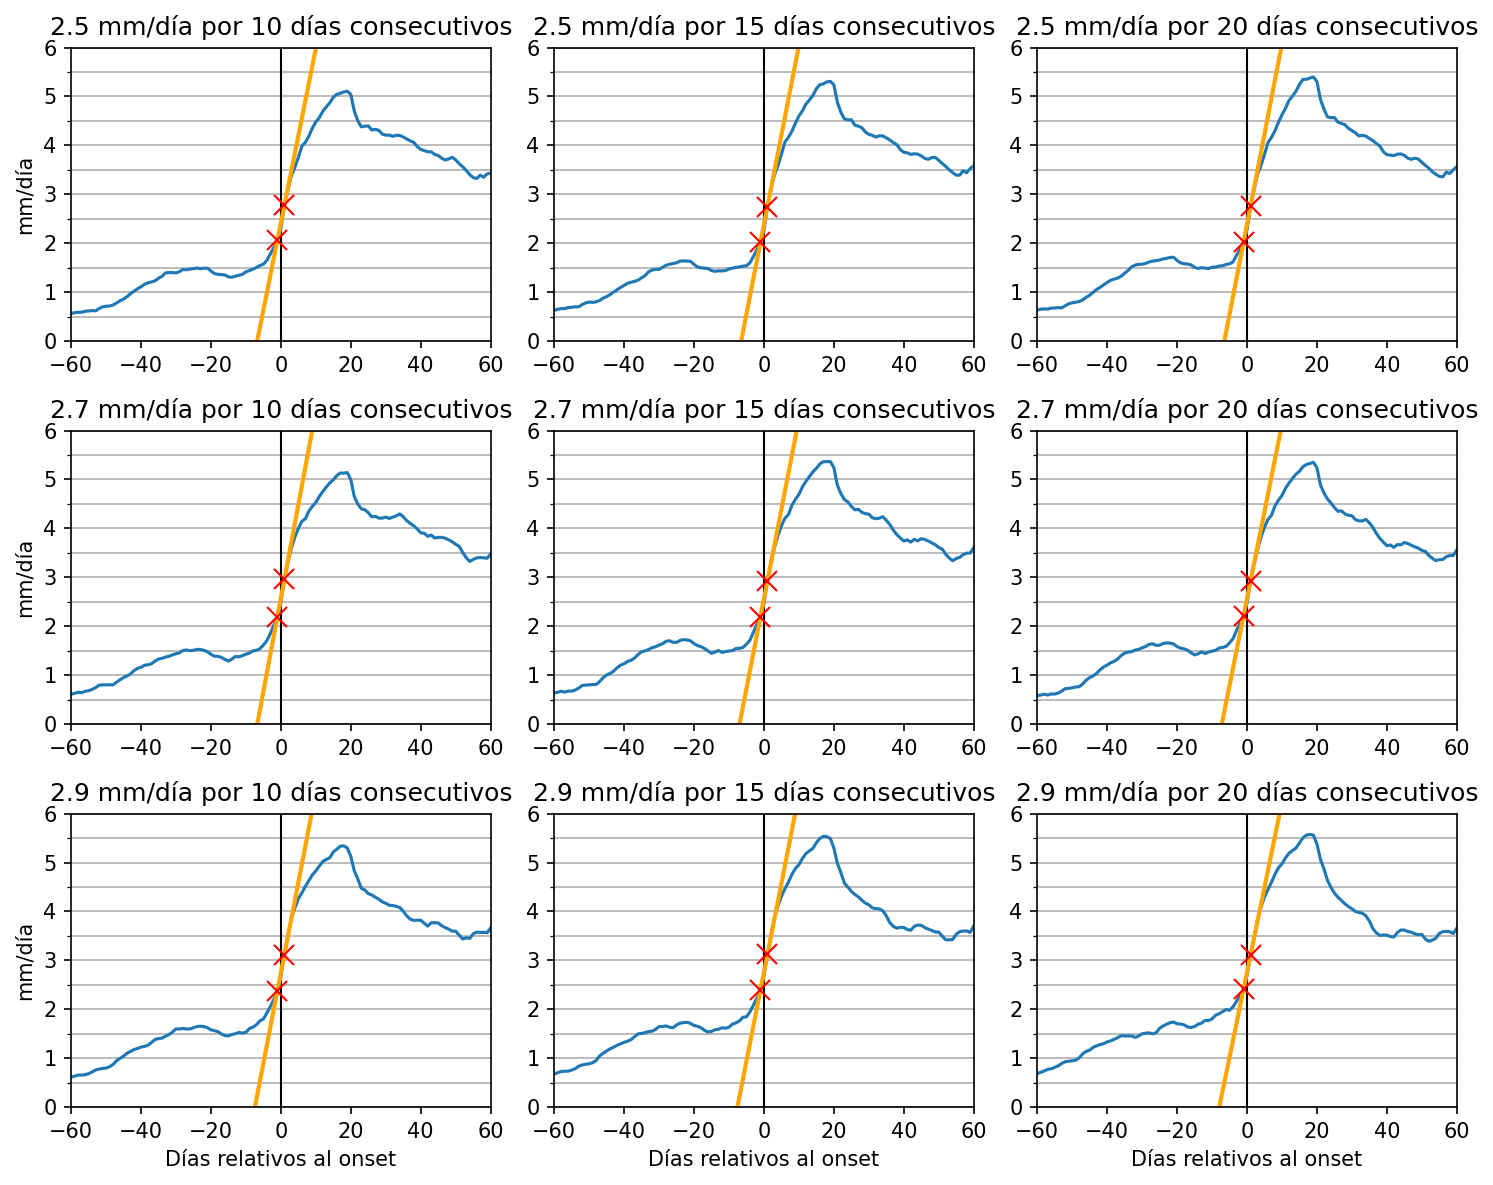

In [99]:
df_mean = df.copy()

# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [2.5, 2.7, 2.9]
dias = [10, 15, 20]

lim = 6
step = [0.5, 0.05]
title = "onset_criteria_CHIRPS.png"

fig, axes = plt.subplots(len(umbral), len(dias))
fig.set_facecolor("w")
fig.set_size_inches(10, 8)
fig.set_dpi(150)

# Probamos para varios días.
for i_n, n in enumerate(dias):
    # Inicio o fin de la racha.
    k = 0
    if rec[0]: k = n

    # Probamos para varios umbrales.
    for i_u, u in enumerate(umbral):
        df_mean_ind = pd.DataFrame(
            df_mean.copy(), columns = ["Cuenca"] )

        c = "Cuenca"

        # Nombre de las columnas dummy.
        proc = [c]
        for i in range(0, n):
            proc.append(c +
                "_" + str(i)) 

        # Traslapa los últimos n días 
        # y da un valor de 1 a cada día 
        # que cumpla con el umbral.
        for i, p in enumerate(proc[1:]):
            df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
            df_mean_ind[p].clip( upper = u,
                inplace = True )
            df_mean_ind[p] = df_mean_ind[p].where(
                df_mean_ind[p] == u, 0)
            df_mean_ind[p] = df_mean_ind[p].where(
                df_mean_ind[p] < u, 1)

        # El índice es uno si los n
        # cumplen con el umbral.
        ind = "Index_" + c
        df_mean_ind[ind] = 0
        for i in range(n):
            df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
        df_mean_ind[ind] = df_mean_ind[ ind
            ].where(df_mean_ind[ind] == n, 0)
        df_mean_ind[ind] = df_mean_ind[ ind
            ].where(df_mean_ind[ind] < n, 1)
        df_mean_ind.drop(proc[1:],
            axis = 1, inplace = True)

        # Crea una tabla con los valores anuales.
        col = []
        name = "Cuenca"
        col.append(name + " - Onset")
        col.append(name + " - Withdrawal")

        date = pd.DataFrame()
        years = range(year_r[0], year_r[1] + 1)

        for j in years:
            # Solo utilizamos valores entre los límites.
            df_year = df_mean_ind[ (df_mean_ind.index.year == j)
                & ( df_mean_ind.index.dayofyear > ( ini[0][0] + k ) )
                & ( df_mean_ind.index.dayofyear < ( ini[0][1] + k ) ) ]

            row = []

            # Fechas.
            row.append( df_year.iloc[:, 1].idxmax() )
            row.append( df_year.iloc[::-1, 1].idxmax() )

            # Agregamos la fila al DataFrame.
            date = date.append([row])

        # Damos formato a las columnas y al índice.
        date.columns = col
        date.index = years
        date.index.name = "Año"
        
        # Recorremos al inicio de la racha de días de precipitación.
        if rec[0]: date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(n, 'D')
        # Longitud de la temporada.
        date[name + " - Length"] = date.iloc[:, 1] - date.iloc[:, 0]

        # Calculamos el shift necesario para alinear las fechas.
        shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
        delta = shift.max()
        shift = shift.max() - shift

        # Creamos un DataFrame con año
        # como columnas y días como filas.
        pre_df = pd.DataFrame(
            df_mean.copy(), columns = [ df_mean.columns[0] ] )
        pre_df["Año"] = pre_df.index.year
        pre_df["Día"] = pre_df.index.dayofyear

        # Convertimos los años a columnas.
        pre_df = pre_df.pivot(index = "Día", columns = "Año")
        pre_df.columns = pre_df.columns.droplevel(0)

        # Alineamos las series de tiempo.
        for j in pre_df.columns:
            pre_df[j] = pre_df[j].shift(shift[j])

        # Promediamos y seleccionamos 120 días.
        pre_df = pre_df.mean(axis = 1)
        pre_df = pre_df.loc[delta - 60: delta + 60]
        pre_df.index = range(-60, 61)

        # Graficamos.
        axes[i_u, i_n].plot( (0, 0), (0, 7), color = "k",
            linewidth = 1 )
        pre_df.plot(ax = axes[i_u, i_n])

        axes[i_u, i_n].set_title(
            f"{u} mm/día por {n} días consecutivos")
        axes[i_u, i_n].set_xlim(-60, 60)
        axes[i_u, i_n].set_ylim(0, lim)

        if i_n == 0: 
            axes[i_u, i_n].set_ylabel("mm/día")
        if i_u == 2: 
            axes[i_u, i_n].set_xlabel("Días relativos al onset")

        for ax in axes.flatten():
            ax.set_yticks( np.arange(0, lim, step[0]), minor = True )
            ax.grid( visible = True, which = "both", axis ="y" )

        # Pendiente del incremento de lluvia.
        y_1 = pre_df.loc[-1]
        y_2 = pre_df.loc[ 1]
        x_1 = -1
        x_2 =  1
        m = ( y_1 - y_2 ) / ( x_1 - x_2 )
        print( f"Umbral: {u} mm/día, {n} días consecutivos, " + 
            f"Pendiente: {m:.3f}" )
        axes[i_u, i_n].plot( ( x_1 + ( 0 - y_1 ) / m, 
            x_1 + ( lim - y_1 ) / m ), (0, lim),
            color = "orange", linewidth = 2 )
        axes[i_u, i_n].plot( x_1, y_1, marker = "x",
            markersize = 10, color = "r")
        axes[i_u, i_n].plot( x_2, y_2, marker = "x",
            markersize = 10, color = "r")

        # Separación adecuada entre gráficas.
        fig.tight_layout()

        # Guardamos el archivo.
        fig.savefig( path_r + title )

Umbral: 1.5 mm/día, 10 días consecutivos, Pendiente: 0.408
Umbral: 1.7 mm/día, 10 días consecutivos, Pendiente: 0.442
Umbral: 1.9 mm/día, 10 días consecutivos, Pendiente: 0.464
Umbral: 1.5 mm/día, 15 días consecutivos, Pendiente: 0.408
Umbral: 1.7 mm/día, 15 días consecutivos, Pendiente: 0.469
Umbral: 1.9 mm/día, 15 días consecutivos, Pendiente: 0.475
Umbral: 1.5 mm/día, 20 días consecutivos, Pendiente: 0.494
Umbral: 1.7 mm/día, 20 días consecutivos, Pendiente: 0.505
Umbral: 1.9 mm/día, 20 días consecutivos, Pendiente: 0.472


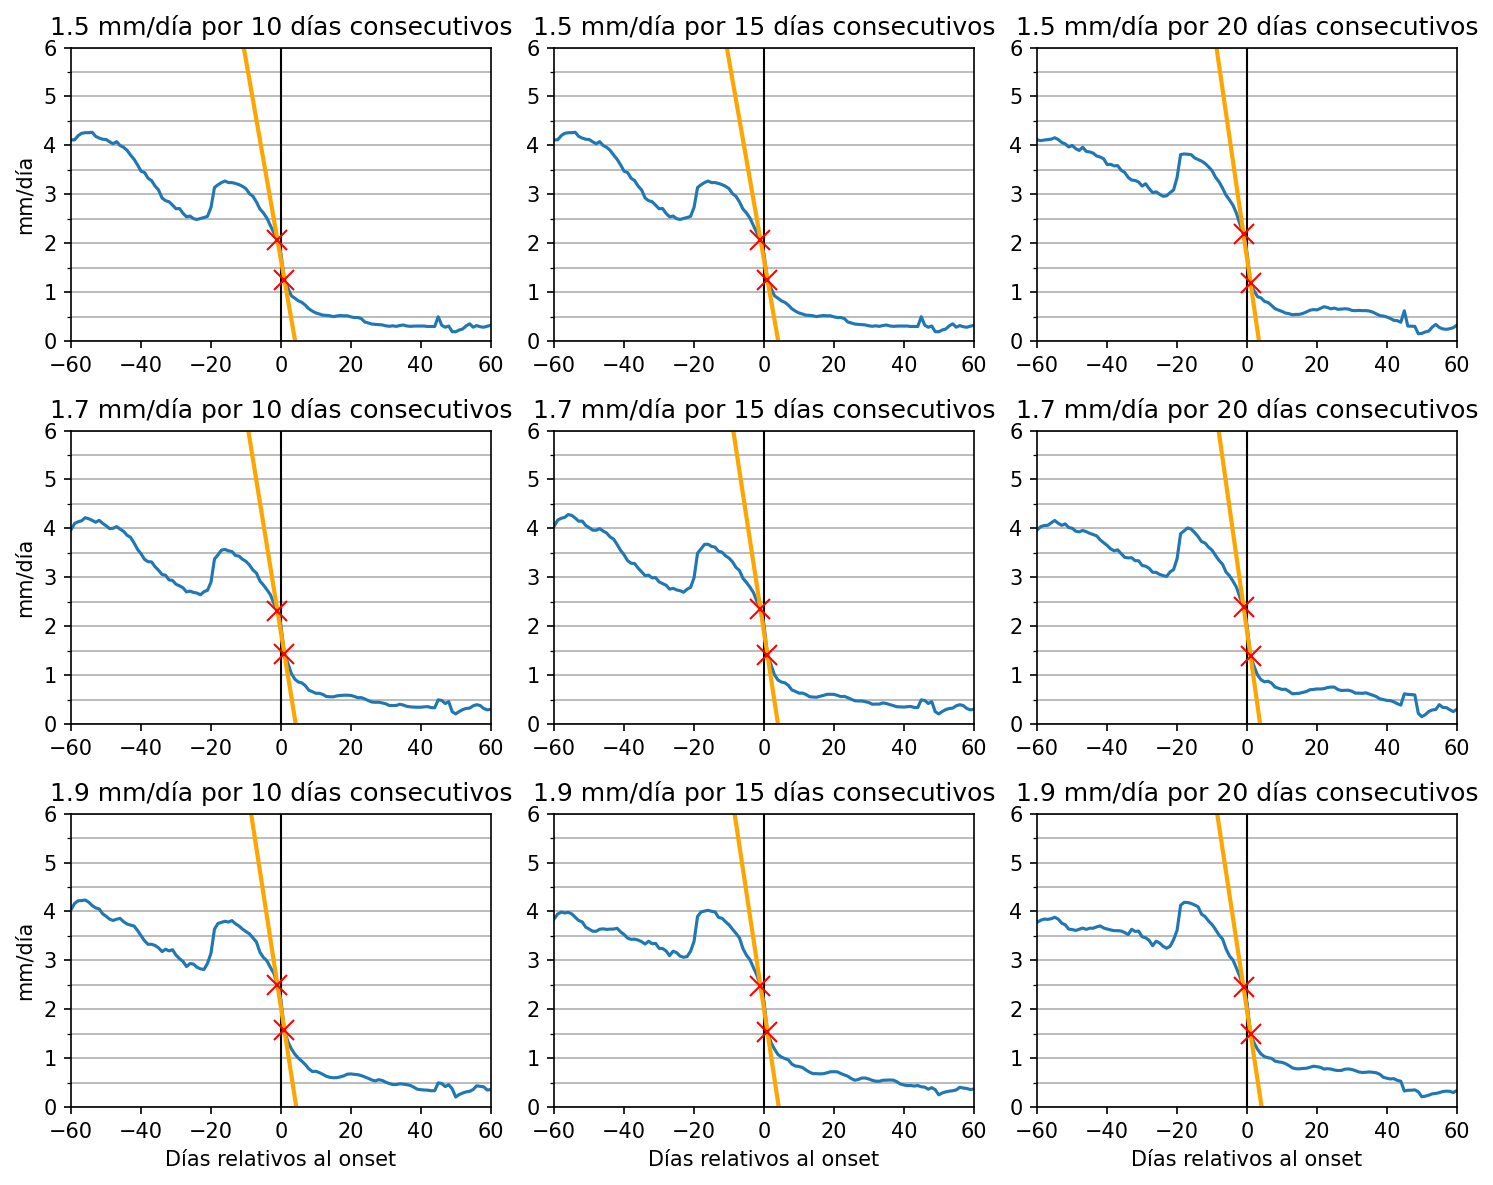

In [100]:
df_mean = df.copy()

# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [1.5, 1.7, 1.9]
dias = [10, 15, 20]

step = [0.5, 0.05]
title = "withdrawal_criteria_CHIRPS.png"

fig, axes = plt.subplots(len(umbral), len(dias))
fig.set_facecolor("w")
fig.set_size_inches(10, 8)
fig.set_dpi(150)

for i_n, n in enumerate(dias):
    k = 0
    if rec[1]: k = n
    
    for i_u, u in enumerate(umbral):
        df_mean_ind = pd.DataFrame(
            df_mean.copy(), columns = ["Cuenca"] )

        c = "Cuenca"

        # Nombre de las columnas dummy.
        proc = [c]
        for i in range(0, n):
            proc.append(c +
                "_" + str(i)) 

        # Traslapa los últimos n días 
        # y da un valor de 1 a cada día 
        # que cumpla con el umbral.
        for i, p in enumerate(proc[1:]):
            df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
            df_mean_ind[p].clip( upper = u,
                inplace = True )
            df_mean_ind[p] = df_mean_ind[p].where(
                df_mean_ind[p] == u, 0)
            df_mean_ind[p] = df_mean_ind[p].where(
                df_mean_ind[p] < u, 1)

        # El índice es uno si los n
        # cumplen con el umbral.
        ind = "Index_" + c
        df_mean_ind[ind] = 0
        for i in range(n):
            df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
        df_mean_ind[ind] = df_mean_ind[ ind
            ].where(df_mean_ind[ind] == n, 0)
        df_mean_ind[ind] = df_mean_ind[ ind
            ].where(df_mean_ind[ind] < n, 1)
        df_mean_ind.drop(proc[1:],
            axis = 1, inplace = True)

        # Crea una tabla con los valores anuales.
        col = []
        name = "Cuenca"
        col.append(name + " - Onset")
        col.append(name + " - Withdrawal")

        date = pd.DataFrame()
        years = range(year_r[0], year_r[1] + 1)

        for j in years:
            # Solo utilizamos valores entre mayo y diciembre.
            df_year = df_mean_ind[ (df_mean_ind.index.year == j)
                & ( df_mean_ind.index.dayofyear > ( ini[1][0] - k ) )
                & ( df_mean_ind.index.dayofyear < ( ini[1][1] - k ) ) ]

            row = []

            # Fechas.
            row.append( df_year.iloc[:, 1].idxmax() )
            row.append( df_year.iloc[::-1, 1].idxmax() )

            # Agregamos la fila al DataFrame.
            date = date.append([row])

        # Damos formato a las columnas y al índice.
        date.columns = col
        date.index = years
        date.index.name = "Año"
        
        # Recorremos al inicio de la racha de días de precipitación.
        if rec[1]: date.iloc[:, 0] = date.iloc[:, 0] + np.timedelta64(n, 'D')
        # Longitud de la temporada.
        date[name + " - Length"] = date.iloc[:, 1] - date.iloc[:, 0]

        # Calculamos el shift necesario para alinear las fechas.
        shift = date.iloc[:, 1].apply(lambda x: x.dayofyear)
        delta = shift.max()
        shift = shift.max() - shift

        # Creamos un DataFrame con año
        # como columnas y días como filas.
        pre_df = pd.DataFrame(
            df_mean.copy(), columns = [ df_mean.columns[0] ] )
        pre_df["Año"] = pre_df.index.year
        pre_df["Día"] = pre_df.index.dayofyear

        # Convertimos los años a columnas.
        pre_df = pre_df.pivot(index = "Día", columns = "Año")
        pre_df.columns = pre_df.columns.droplevel(0)

        # Alineamos las series de tiempo.
        for j in pre_df.columns:
            pre_df[j] = pre_df[j].shift(shift[j])

        # Promediamos y seleccionamos 120 días.
        pre_df = pre_df.mean(axis = 1)
        a = pre_df[0:60]
        a.index = np.arange(367, 367 + 60)
        pre_df = pre_df.append(a)
        pre_df = pre_df.loc[delta - 60: delta + 60]
        pre_df.index = range(-60, 61)

        # Graficamos.
        axes[i_u, i_n].plot( (0, 0), (0, 7), color = "k",
            linewidth = 1 )
        pre_df.plot(ax = axes[i_u, i_n])

        axes[i_u, i_n].set_title(
            f"{u} mm/día por {n} días consecutivos")
        axes[i_u, i_n].set_xlim(-60, 60)
        axes[i_u, i_n].set_ylim(0, lim)

        # Pendiente del incremento de lluvia.
        y_1 = pre_df.loc[-1]
        y_2 = pre_df.loc[ 1]
        x_1 = -1
        x_2 =  1
        m = ( y_1 - y_2 ) / ( x_1 - x_2 )
        print( f"Umbral: {u} mm/día, {n} días consecutivos, " + 
            f"Pendiente: {-m:.3f}")
        axes[i_u, i_n].plot( ( x_1 + ( 0 - y_1 ) / m, 
            x_1 + ( lim - y_1 ) / m ), (0, lim),
            color = "orange", linewidth = 2 )
        axes[i_u, i_n].plot( x_1, y_1, marker = "x",
            markersize = 10, color = "r")
        axes[i_u, i_n].plot( x_2, y_2, marker = "x",
            markersize = 10, color = "r")

        if i_n == 0: 
            axes[i_u, i_n].set_ylabel("mm/día")
        if i_u == 2: 
            axes[i_u, i_n].set_xlabel("Días relativos al withdrawal")

        for ax in axes.flatten():
            ax.set_yticks( np.arange(0, lim, step[0]), minor = True )
            ax.grid( visible = True, which = "both", axis ="y" )

        # Separación adecuada entre gráficas.
        fig.tight_layout()

        # Guardamos el archivo.
        fig.savefig( path_r + title )

Umbral: 1.9 mm/día, [10, 20] días consecutivos, Pendiente: 0.387
Umbral: 1.9 mm/día, [10, 20] días consecutivos, Pendiente: -0.512


,Cuenca - Onset,Cuenca - Withdrawal,Cuenca - Length,Onset - date,Withdrawal - date
count,40.000000,40.000000,40,1970-02-10 00:00:00.000000000,1970-02-10 00:00:00.000000000
mean,154.450000,287.600000,133 days 03:36:00,1970-06-04 10:48:00.000000000,1970-10-15 14:24:00.000000000
std,15.258373,16.149621,23 days 21:37:28.520793341,1970-01-16 06:12:03.433176221,1970-01-17 03:35:27.248960726
min,121.000000,257.000000,91 days 00:00:00,1970-05-02 00:00:00.000000000,1970-09-15 00:00:00.000000000
25%,142.000000,276.000000,116 days 06:00:00,1970-05-23 00:00:00.000000000,1970-10-04 00:00:00.000000000
50%,156.500000,287.000000,135 days 12:00:00,1970-06-06 12:00:00.000000000,1970-10-15 00:00:00.000000000
75%,166.250000,295.000000,146 days 18:00:00,1970-06-16 06:00:00.000000000,1970-10-23 00:00:00.000000000
max,178.000000,322.000000,191 days 00:00:00,1970-06-28 00:00:00.000000000,1970-11-19 00:00:00.000000000


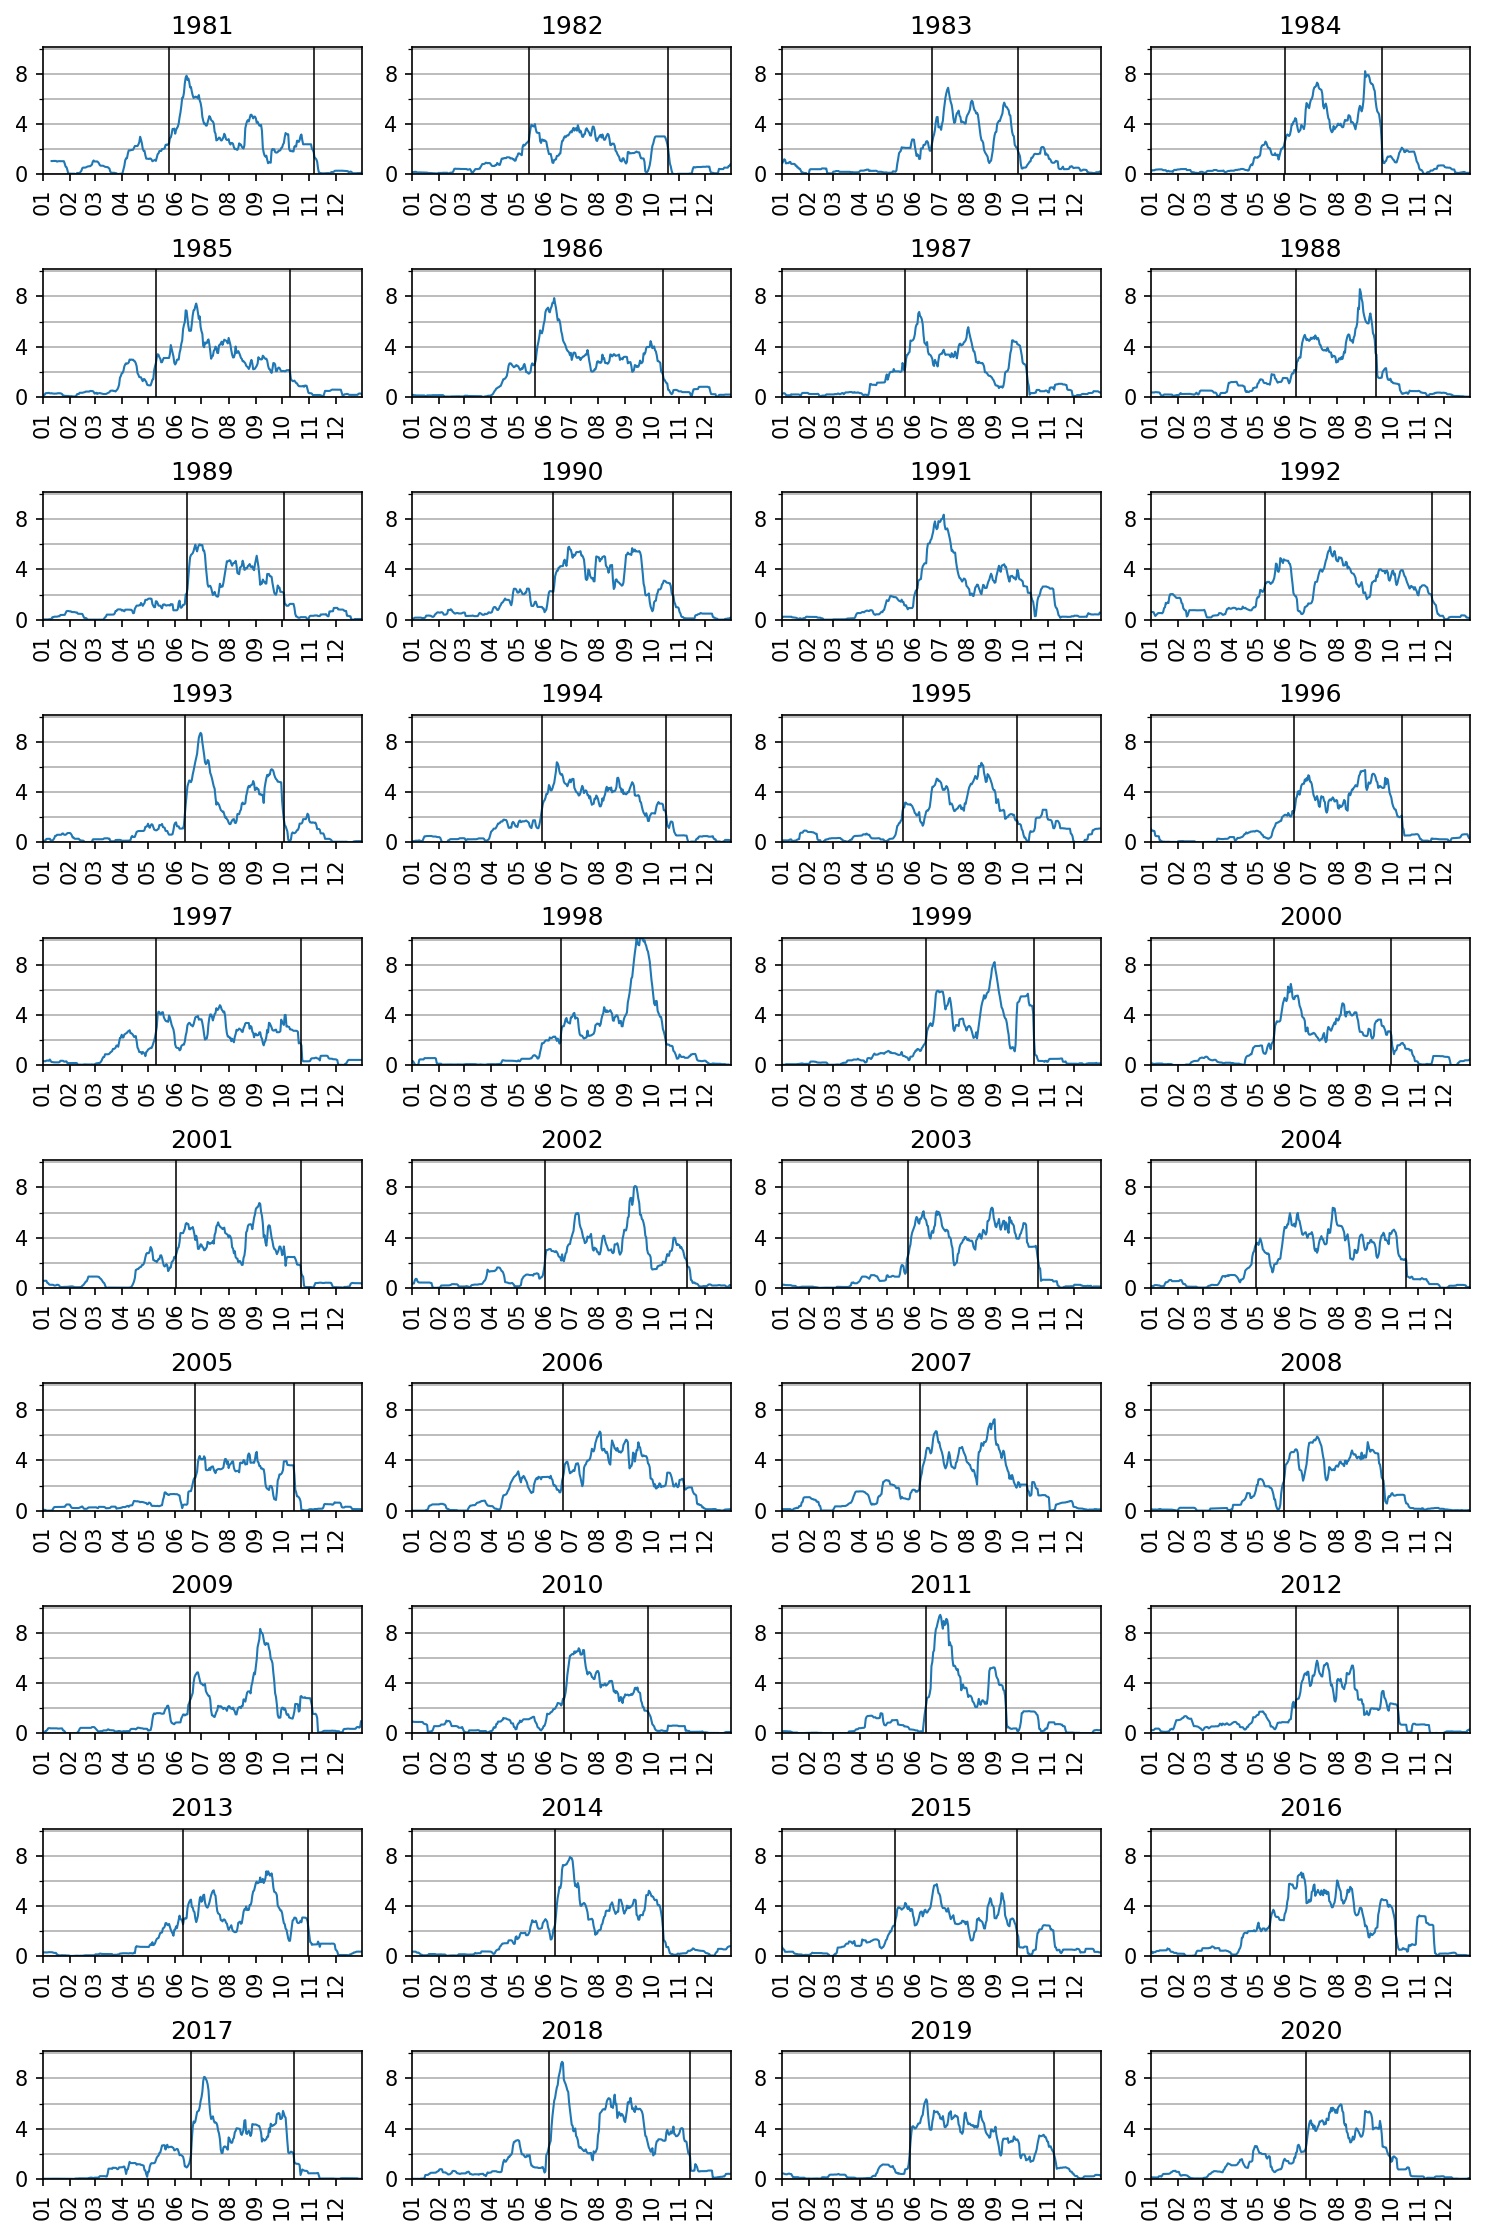

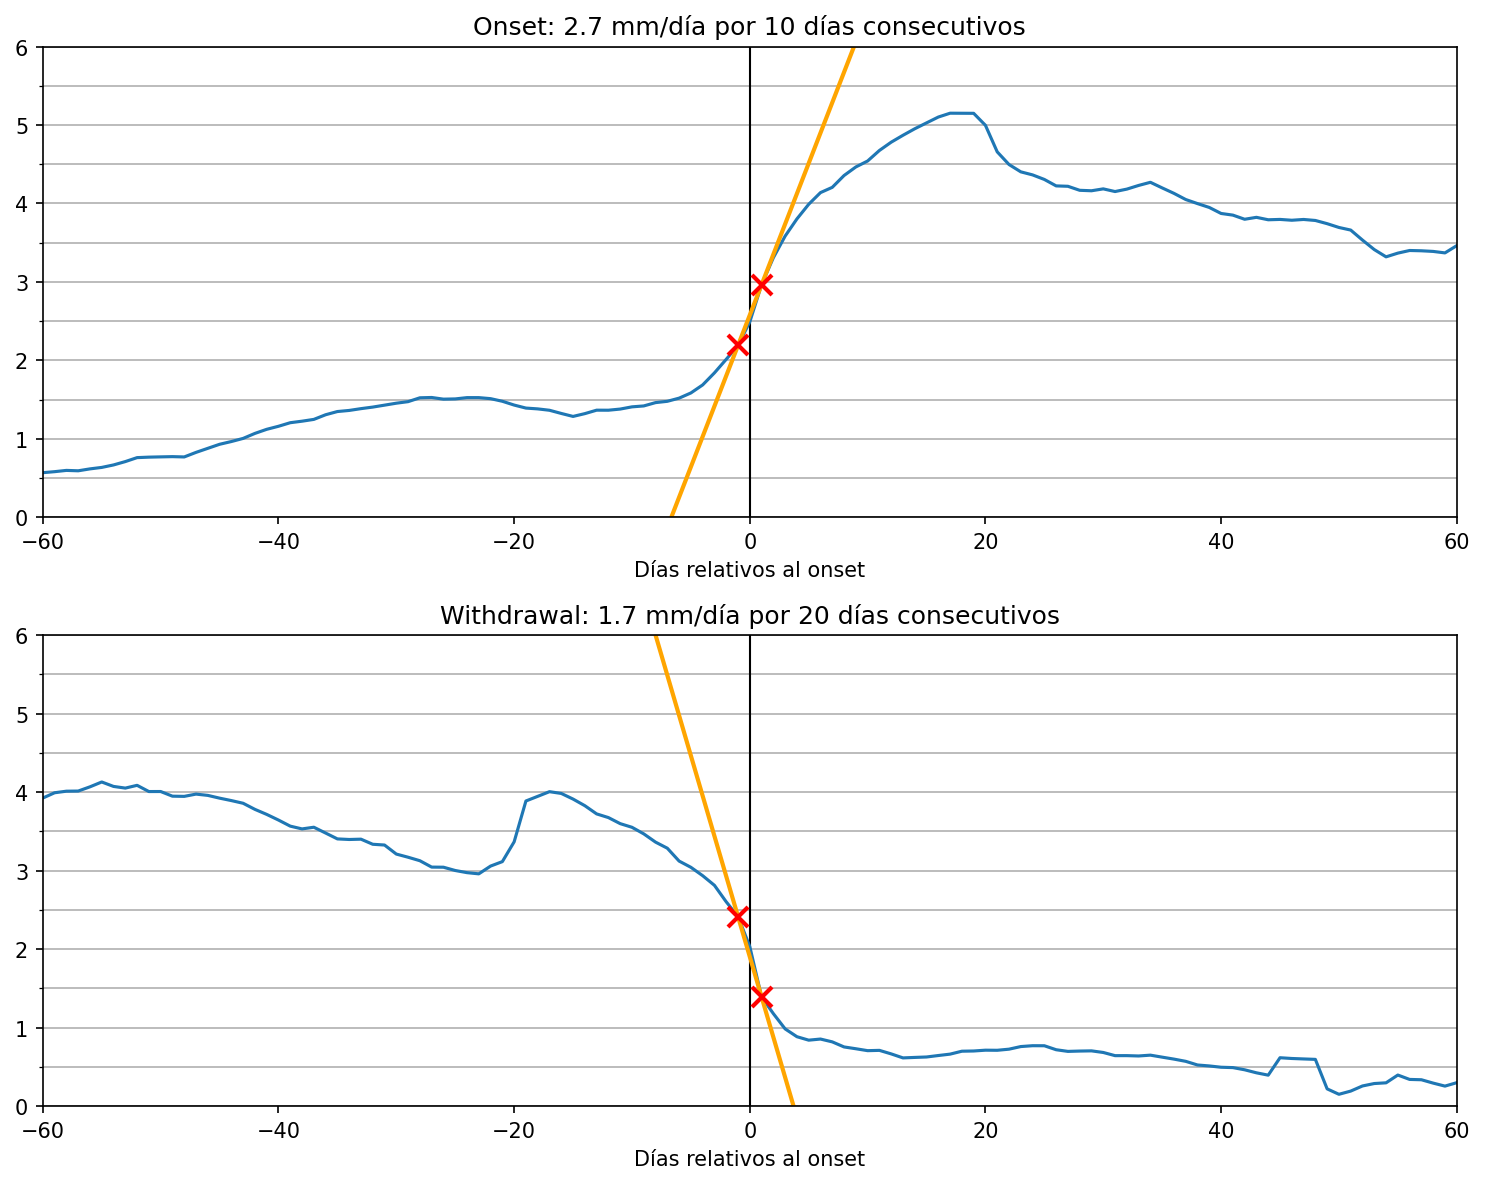

In [101]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = [2.7, 1.7]
n = [10, 20]
# Inicio o fin de la racha de precipitación.
k = [0, 0]
for i in range( len(rec) ):
    if rec[i]:
        k[i] = n[i]
onset_n = ["Onset", "Withdrawal"]

df_mean_ind = pd.DataFrame(
    df_mean.copy(), columns = ["Cuenca"] )

years = range(year_r[0], year_r[1] + 1)
c = "Cuenca"
title = "onset_withdrawal_CHIRPS_igual_2_25.png"

# Onset.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[0]):
    proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral[0],
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral[0], 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral[0], 1)
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n[0]):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] == n[0], 0 )
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] < n[0], 1 )
df_mean_ind[ind] = df_mean_ind[ind].where(
    df_mean_ind.index.month.isin( range(5, 12) ), 0 )
df_mean_ind.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & ( df_mean_ind.index.dayofyear > ( ini[0][0] + k[0] - 1 ) )
        & ( df_mean_ind.index.dayofyear < ( ini[0][1] + k[0] + 1 ) ) ]
    row = []
    # Fechas.
    row.append( df_year.iloc[:, 1].idxmax() )
    row.append( None )
    # Agregamos la fila al DataFrame.
    date = date.append([row])
# Recorremos al inicio de la racha de días de precipitación.
if rec[0]: date.iloc[:, 0] = date.iloc[:, 0] - np.timedelta64(n[0], 'D')

# Withdrawal.
# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n[1]):
    proc.append(c + "_" + str(i)) 
# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral[1],
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral[1], 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral[1], 1)
# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n[1]):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] == n[1], 0 )
df_mean_ind[ind] = df_mean_ind[ind].where( df_mean_ind[ind] < n[1], 1 )
df_mean_ind[ind] = df_mean_ind[ind].where(
    df_mean_ind.index.month.isin( range(5, 12) ), 0 )
df_mean_ind.drop( proc[1:], axis = 1, inplace = True )
# Crea una tabla con los valores anuales.
col = []
name = "Cuenca"
col.append(name + " - Onset")
col.append(name + " - Withdrawal")
date_2 = pd.DataFrame()
for j in years:
    # Solo utilizamos valores entre mayo y noviembre.
    df_year = df_mean_ind[ (df_mean_ind.index.year == j)
        & ( df_mean_ind.index.dayofyear > ( ini[1][0] - k[1] - 1 ) )
        & ( df_mean_ind.index.dayofyear < ( ini[1][1] - k[1] + 1 ) ) ]
    row = []
    # Fechas.
    row.append( None )
    #row.append( df_year.iloc[:, 1].idxmax() )
    row.append( df_year.iloc[::-1, 1].idxmax() )
    # Agregamos la fila al DataFrame.
    date_2 = date_2.append([row])
# Recorremos al inicio de la racha de días de precipitación.
if rec[1]: date_2.iloc[:, 1] = date_2.iloc[:, 1] + np.timedelta64(n[1], 'D')

# Unimos onset y withdrawal.
date.iloc[:, 1] = date_2.iloc[:, 1]

# Damos formato a las columnas y al índice.
date.columns = col
date.index = years
date.index.name = "Año"

# Longitud de la temporada.
date[name + " - Length"] = date.iloc[:, 1] - date.iloc[:, 0]

# Calculamos el shift necesario para alinear las fechas.
shift = date.iloc[:, 0].apply(lambda x: x.dayofyear)
shift_2 = date.iloc[:, 1].apply(lambda x: x.dayofyear)

# Guarda las series de tiempo.
date.to_csv(path_d + "onset_CHIRPS.csv")
shift.to_csv(path_d + "shift_CHIRPS.csv")
shift_2.to_csv(path_d + "shift_withdrawal_CHIRPS.csv")

year = range(year_r[0], year_r[1] + 1)

# Graficamos.
fig, axes = plt.subplots(10, 4)
axes = axes.flatten()
fig.set_facecolor("w")
fig.set_size_inches(10, 15)
fig.set_dpi(150)

xtick_lab = [ f"{x:02d}" for x in range(1, 13) ]


for i in range( len(year) ):
    df_year = df_mean_ind[ df_mean_ind.index.year == year[i] ]

    # Fechas.
    onset = date.iloc[date.index == year[i], 0]
    withdrawal = date.iloc[date.index == year[i], 1]

    axes[i].plot(df_year.iloc[:, 0], linewidth = 1)
    #ax.plot(df_year.iloc[:, 1])

    # Onset y withdrawal.
    axes[i].plot( (onset, onset), (0, 12),
        color = "k", linewidth = 0.75 )
    axes[i].plot( (withdrawal, withdrawal), (0, 12), 
        color = "k", linewidth = 0.75 ) 

    axes[i].set_title(year[i])
    axes[i].set_yticks( range(0, 14, 4), minor = False )
    axes[i].set_yticks( range(0, 14, 2), minor = True)
    axes[i].grid(axis = "y", which = "both")
    #axes[0].set_ylabel("Precipitación diaria [mm]")
    #axes[0].set_xlabel("Tiempo")
    axes[i].set_ylim( df_mean.min().values[0], df_mean.max().values[0])
    axes[i].set_xlim( pd.to_datetime( str(year[i]) + "-01-01" ),
        pd.to_datetime( str(year[i]) + "-12-31") )
    # Formato de fecha.
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%m"))
    axes[i].set_xticks( axes[i].get_xticks(), xtick_lab, rotation = 90 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig( path_r + title )


# Composite.

# Cantidad de días a recorrer.
delta = shift.max()
delta_2 = shift_2.max()
shift = delta - shift
shift_2 = delta_2 - shift_2

# Graficamos.
fig, axes = plt.subplots(2)
fig.set_facecolor("w")
fig.set_size_inches(10, 8)
fig.set_dpi(150)

shift_o = [shift, shift_2]
delta_o = [delta, delta_2]

# Creamos un DataFrame con año
# como columnas y días como filas.
pre_df = pd.DataFrame( df_mean.copy(), columns = [ df_mean.columns[0] ] )
pre_df["Año"] = pre_df.index.year
pre_df["Día"] = pre_df.index.dayofyear

# Convertimos los años a columnas.
pre_df = pre_df.pivot(index = "Día", columns = "Año")
pre_df.columns = pre_df.columns.droplevel(0)

pre_df = pre_df.iloc[:, :-1]

for i in [0, 1]:
    pre_df_2 = pre_df.copy()

    # Alineamos las series de tiempo.
    for j in pre_df_2.columns:
        pre_df_2[j] = pre_df_2[j].shift(shift_o[i][j])

    # Promediamos y seleccionamos 120 días.
    pre_df_2 = pre_df_2.mean(axis = 1)
    if i == 1:
        a = pre_df_2[0:60]
        a.index = np.arange(367, 367 + 60)
        pre_df_2 = pre_df_2.append(a)
    pre_df_2 = pre_df_2.loc[delta_o[i] - 60: delta_o[i] + 60]
    pre_df_2.index = range(-60, 61)

    # Graficamos.
    axes[i].plot( (0, 0), (0, 7), color = "k", linewidth = 1 )
    pre_df_2.plot(ax = axes[i])

    axes[i].set_title( ( f"{onset_n[i]}: {umbral[i]} "
        + f"mm/día por {n[i]} días consecutivos" ) )
    axes[i].set_xlim(-60, 60)
    axes[i].set_ylim(0, lim)

    # Pendiente del incremento de lluvia.
    y_1 = pre_df_2.loc[-1]
    y_2 = pre_df_2.loc[ 1]
    x_1 = -1
    x_2 =  1
    m = ( y_1 - y_2 ) / ( x_1 - x_2 )
    print( f"Umbral: {u} mm/día, {n} días consecutivos, " + 
        f"Pendiente: {m:.3f}" )
    axes[i].plot( ( x_1 + ( 0 - y_1 ) / m, 
        x_1 + ( lim - y_1 ) / m ), (0, lim),
        color = "orange", linewidth = 2 )
    axes[i].plot( x_1, y_1, marker = "x",
        markersize = 10, mew = 2, color = "r" )
    axes[i].plot( x_2, y_2, marker = "x",
        markersize = 10, mew = 2, color = "r" )

    if i_n == 0: 
        axes[i].set_ylabel("mm/día")
    if i_u == 2: 
        axes[i].set_xlabel( "Días relativos al " onset_n[i].lower() )

    for ax in axes.flatten():
        ax.set_yticks( np.arange(0, lim, step[0]), minor = True )
        ax.grid( visible = True, which = "both", axis ="y" )

    # Separación adecuada entre gráficas.
    fig.tight_layout()

    # Guardamos el archivo.
    #fig_s[i].savefig( path_r + title )

date_2 = date.copy()
date_2.iloc[:, 0] = date_2.iloc[:, 0].apply(lambda x: x.dayofyear)
date_2.iloc[:, 1] = date_2.iloc[:, 1].apply(lambda x: x.dayofyear)

stats = date_2.describe()

stats["Onset - date"] = pd.to_datetime(stats.iloc[:, 0], unit="D")
stats["Withdrawal - date"] = pd.to_datetime(stats.iloc[:, 1], unit="D")

stats

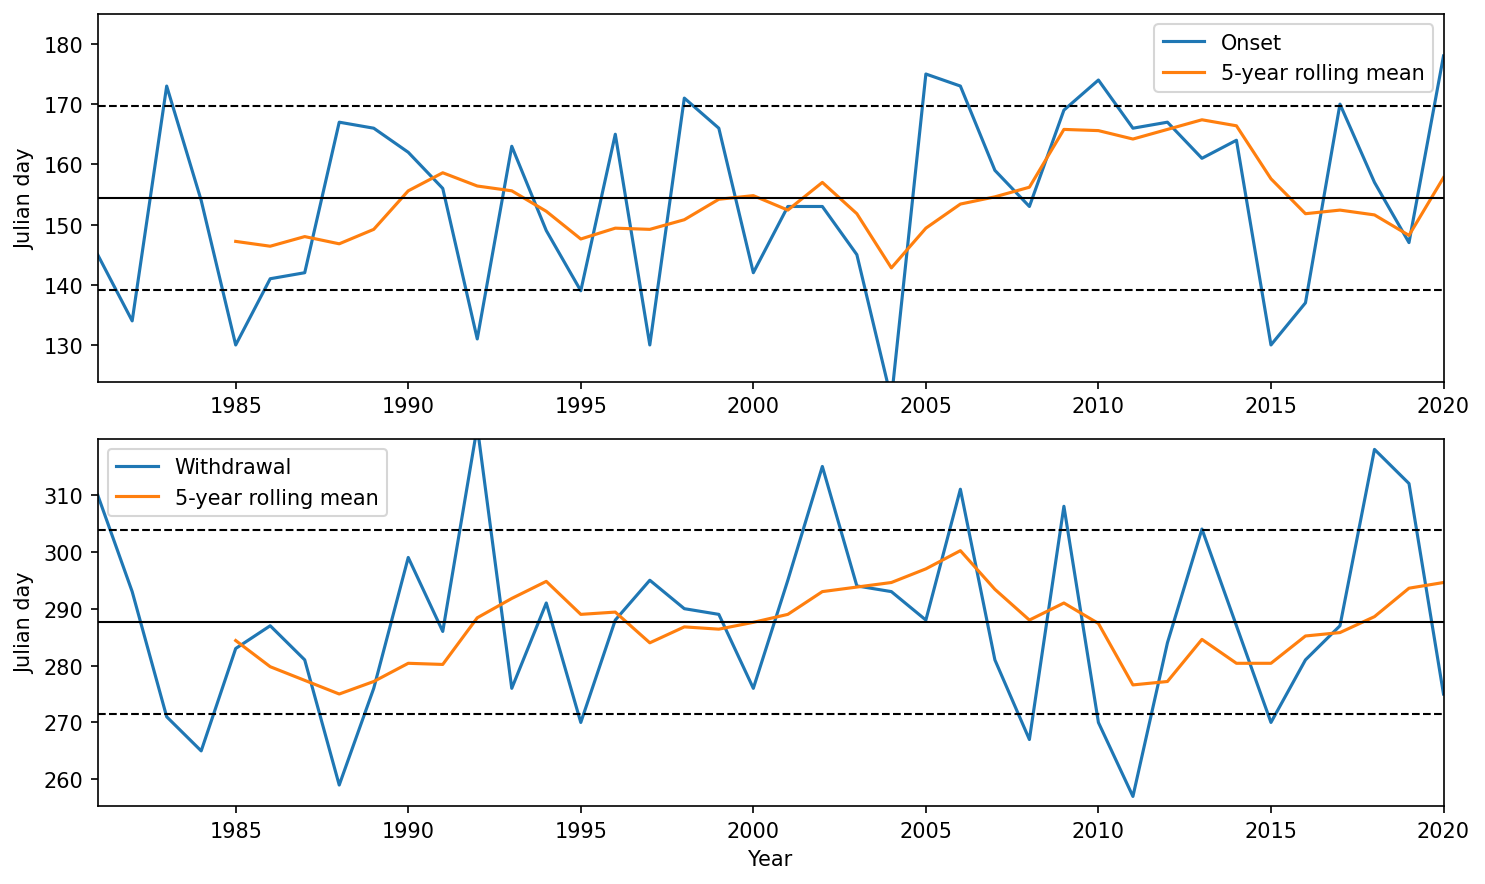

In [102]:
# Serie de tiempo de onset y withdrawal.

# Graficamos.
fig, axes = plt.subplots(2)
fig.set_facecolor("w")
fig.set_size_inches(10, 6)
fig.set_dpi(150)

# Formato de ejes.
for i in range(len(axes)):
    date_2.iloc[:, i].plot(ax = axes[i])
    date_2.iloc[:, i].rolling(window = 5).mean().plot(ax = axes[i])
    axes[i].set_ylabel("Julian day")
    axes[i].set_xlabel("")
    axes[i].legend([onset_n[i], "5-year rolling mean"])
    axes[i].set_xlim(*year_r)
    axes[i].set_ylim(stats.iloc[1, i] - stats.iloc[2, i]*2,
        stats.iloc[1, i] + stats.iloc[2, i]*2)
    
    # Media.
    axes[i].plot( year_r, (stats.iloc[1, i],)*2,
        color = "k", linewidth = 1 )

    # Desviación estándar.
    axes[i].plot( year_r, (stats.iloc[1, i] - stats.iloc[2, i],)*2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    axes[i].plot( year_r, (stats.iloc[1, i] + stats.iloc[2, i],)*2,
        color = "k", linestyle = "dashed", linewidth = 1 )
    #axes[i].plot( year_r, (stats.iloc[1, i] - stats.iloc[2, i] * 2, ) * 2,
    #    color = "k", linestyle = "dashed", linewidth = 1 )
    #axes[i].plot( year_r, (stats.iloc[1, i] + stats.iloc[2, i] * 2, ) * 2,
    #    color = "k", linestyle = "dashed", linewidth = 1 )

    # Límites.
    #axes[i].plot( year_r, (ini[i][0] + 0*k[i],)*2,
    #    color = "b", linewidth = 1 )
    #axes[i].plot( year_r, (ini[i][1] + 0*k[i],)*2,
    #    color = "b", linewidth = 1 )

axes[i].set_xlabel("Year")

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "comparacion_viento_pre.png")

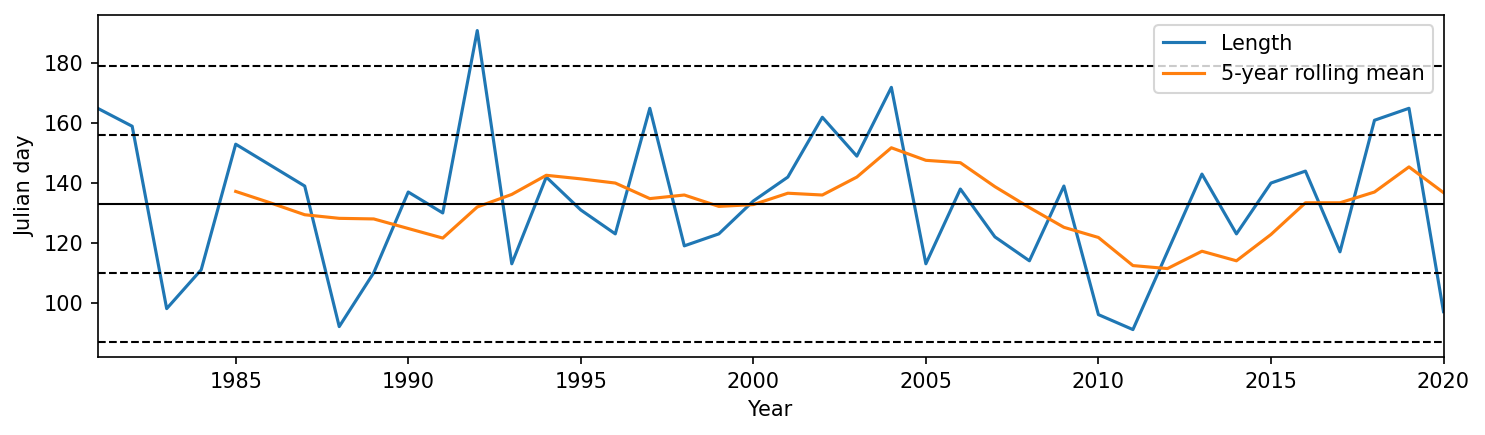

In [103]:
# Serie de tiempo de duración.

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

# Formato de ejes.
date_2.iloc[:, 2].dt.days.plot(ax = ax)
date_2.iloc[:, 2].dt.days.rolling(window = 5).mean().plot(ax = ax)
ax.set_ylabel("Julian day")
ax.set_xlabel("Year")
ax.legend(["Length", "5-year rolling mean"])
ax.set_xlim(*year_r)
#ax.set_ylim(stats.iloc[1, 2].days - stats.iloc[2, 2].days*2,
#    stats.iloc[1, 2].days + stats.iloc[2, 2].days*2)


ax.plot( year_r, (stats.iloc[1, 2].days,)*2, color = "k", linewidth = 1 )

# Desviación estándar.
ax.plot( year_r, (stats.iloc[1, 2].days - stats.iloc[2, 2].days,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats.iloc[1, 2].days + stats.iloc[2, 2].days,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats.iloc[1, 2].days - stats.iloc[2, 2].days*2,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats.iloc[1, 2].days + stats.iloc[2, 2].days*2,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "comparacion_viento_pre.png")

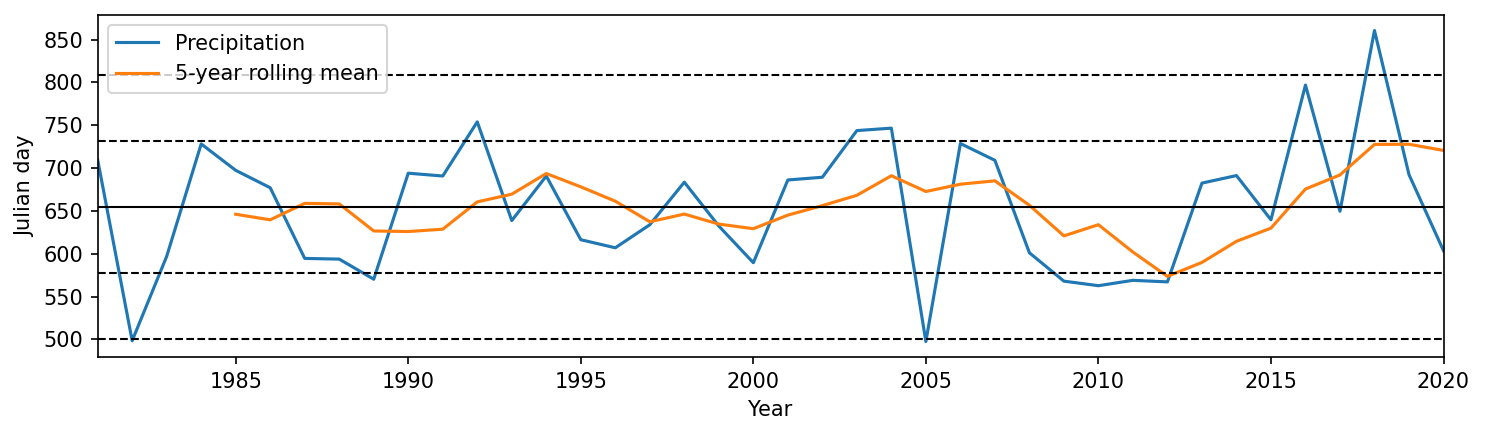

In [104]:
# Serie de tiempo de precipitación.

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 3)
fig.set_dpi(150)

pre = df.groupby(df.index.year).sum()
stats_pre = pre.describe()

# Formato de ejes.
pre["Cuenca"].plot(ax = ax)
pre["Cuenca"].rolling(window = 5).mean().plot(ax = ax)
ax.set_ylabel("Julian day")
ax.set_xlabel("Year")
ax.legend(["Precipitation", "5-year rolling mean"])
ax.set_xlim(*year_r)
#ax.set_ylim(stats_pre.iloc[1, 0] - stats_pre.iloc[2, 0]*2,
#    stats_pre.iloc[1, 0] + stats_pre.iloc[2, 0]*2)

# Media.
ax.plot( year_r, (stats_pre.iloc[1, 0],)*2, color = "k", linewidth = 1 )

# Desviación estándar.
ax.plot( year_r, (stats_pre.iloc[1, 0] - stats_pre.iloc[2, 0],)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats_pre.iloc[1, 0] + stats_pre.iloc[2, 0],)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats_pre.iloc[1, 0] - stats_pre.iloc[2, 0]*2,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )
ax.plot( year_r, (stats_pre.iloc[1, 0] + stats_pre.iloc[2, 0]*2,)*2,
    color = "k", linestyle = "dashed", linewidth = 1 )

# Separación adecuada entre gráficas.
fig.tight_layout()

# Guardamos el archivo.
fig.savefig(path_r + "comparacion_viento_pre.png")

In [105]:
# Valores anómalos y estadísticas de precipitación.

onset_el = [None] * 2
withdrawal_el = [None] * 2
length_el = [None] * 2
pre_el = [None] * 2

i = 0

onset_el[0] = date_2.loc[( date_2.iloc[:, i]
    < ( stats.iloc[1, i] - stats.iloc[2, i] )),
    date_2.columns[i]].index.values
onset_el[1] = date_2.loc[(date_2.iloc[:, i]
    > ( stats.iloc[1, i] + stats.iloc[2, i] )),
    date_2.columns[i]].index.values

i = 1

withdrawal_el[0] = date_2.loc[( date_2.iloc[:, i]
    < ( stats.iloc[1, i] - stats.iloc[2, i] )),
    date_2.columns[i]].index.values
withdrawal_el[1] = date_2.loc[(date_2.iloc[:, i]
    > ( stats.iloc[1, i] + stats.iloc[2, i] )),
    date_2.columns[i]].index.values

i = 2

length_el[0] = date_2.loc[( date_2.iloc[:, i].dt.days
    < ( stats.iloc[1, i].days - stats.iloc[2, i].days )),
    date_2.columns[i]].index.values
length_el[1] = date_2.loc[(date_2.iloc[:, i].dt.days
    > ( stats.iloc[1, i].days + stats.iloc[2, i].days )),
    date_2.columns[i]].index.values

pre_el[0] = pre[pre < ( stats_pre.iloc[1] - stats_pre.iloc[2] )
    ].dropna().index.values
pre_el[1] = pre[pre > ( stats_pre.iloc[1] + stats_pre.iloc[2] )
    ].dropna().index.values


print( ( "Onset\n" + f"Early dates: {onset_el[0]}\n"
    + f"Late dates: {onset_el[1]}\n" ) )
print( ( "Withdrawal\n" + f"Early dates: {withdrawal_el[0]}\n"
    + f"Late dates: {withdrawal_el[1]}\n" ) )
print( ( "Length\n" + f"Short dates: {length_el[0]}\n"
    + f"Long dates: {length_el[1]}\n" ) )
print( ( "Precipitation\n" + f"Low dates: {pre_el[0]}\n"
    + f"High dates: {pre_el[1]}" ) )

stats_pre 

Onset
Early dates: [1982 1985 1992 1995 1997 2004 2015 2016]
Late dates: [1983 1998 2005 2006 2010 2017 2020]

Withdrawal
Early dates: [1983 1984 1988 1995 2008 2010 2011 2015]
Late dates: [1981 1992 2002 2006 2009 2013 2018 2019]

Length
Short dates: [1983 1988 2010 2011 2020]
Long dates: [1981 1982 1992 1997 2002 2004 2018 2019]

Precipitation
Low dates: [1982 1989 2005 2009 2010 2011 2012]
High dates: [1992 2003 2004 2016 2018]


,Cuenca
count,40.000000
mean,654.548340
std,77.103640
min,497.394220
25%,596.297837
50%,663.333400
75%,694.881022
max,860.685873
